# 3. Example forward pass of data through model: 

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Any
import math
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from tqdm import tqdm


### Loading the dataset:

In [2]:
train_dataset_path = "../dataset/classification/FingerMovements/train.pt"
train_data = torch.load(train_dataset_path)
train_data

{'samples': tensor([[[ 41.8000,  55.2000,  -8.6000,  ...,  16.9000,  42.2000,  13.0000],
          [ 44.8000,  53.8000,  -3.6000,  ...,  24.5000,  35.0000,  26.6000],
          [ 47.1000,  59.9000,  14.4000,  ...,  24.5000,  41.7000,  52.5000],
          ...,
          [ 69.8000,  17.5000,  23.3000,  ...,  51.9000,  51.5000,  -3.5000],
          [ 72.6000,  28.0000,  35.9000,  ...,  59.6000,  58.5000,  -3.2000],
          [ 76.1000,  12.1000,  23.2000,  ...,  57.3000,  46.9000,  -2.6000]],
 
         [[132.0000,  99.7000,  18.7000,  ..., -11.2000, -21.7000, -41.3000],
          [137.0000,  95.8000,   0.8000,  ..., -11.6000, -21.1000, -40.2000],
          [148.0000,  99.5000,  20.0000,  ..., -13.8000, -23.6000, -33.3000],
          ...,
          [ 78.1000, -39.9000,   0.9000,  ..., -31.9000, -57.8000, -51.1000],
          [ 90.5000, -10.2000,  31.6000,  ..., -19.9000, -44.6000, -45.4000],
          [ 85.7000, -37.4000,   7.3000,  ..., -25.7000, -45.6000, -42.5000]],
 
         [[ 69.40

#### Setting up the dataset: 

In [3]:
def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked

    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)

    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask

class ImputationDataset(Dataset):
    """Dynamically computes missingness (noise) mask for each sample"""

    def __init__(self, data, mean_mask_length=3, masking_ratio=0.15,
                 mode='separate', distribution='geometric', exclude_feats=None):
        super(ImputationDataset, self).__init__()

        # self.data = data  # this is a subclass of the BaseData class in data.py
        self.data = data["samples"]
        self.labels = data["labels"]

        # Normalise features: 
        self.means = self.data.mean(dim=[0, 1]) 
        self.stds = self.data.std(dim=[0, 1]) 

        # Normalize
        self.data = (self.data - self.means) / self.stds

        

        # self.feature_df = self.data.feature_df.loc[self.IDs]

        self.masking_ratio = masking_ratio
        self.mean_mask_length = mean_mask_length
        self.mode = mode
        self.distribution = distribution
        self.exclude_feats = exclude_feats

    def __getitem__(self, ind):
        """
        For a given integer index, returns the corresponding (seq_length, feat_dim) array and a noise mask of same shape
        Args:
            ind: integer index of sample in dataset
        Returns:
            X: (seq_length, feat_dim) tensor of the multivariate time series corresponding to a sample
            mask: (seq_length, feat_dim) boolean tensor: 0s mask and predict, 1s: unaffected input
            ID: ID of sample
        """

        # X = self.feature_df.loc[self.IDs[ind]].values  # (seq_length, feat_dim) array
        X = self.data[ind].numpy()
        label = self.labels[ind]

        mask = noise_mask(X, self.masking_ratio, self.mean_mask_length, self.mode, self.distribution,
                          self.exclude_feats)  # (seq_length, feat_dim) boolean array

        return torch.from_numpy(X), torch.from_numpy(mask), label

    def update(self):
        self.mean_mask_length = min(20, self.mean_mask_length + 1)
        self.masking_ratio = min(1, self.masking_ratio + 0.05)

    def __len__(self):
        return self.data.shape[0]
    


imputation_dataset = ImputationDataset(train_data)
sample, mask, label = imputation_dataset[0]
sample[0], mask[0]

(tensor([-9.5397e-01,  6.1665e-01, -3.7655e-01, -2.6380e-01,  1.1476e+00,
          9.5103e-01,  5.6980e-01,  9.6900e-01,  1.0436e+00, -4.6374e-01,
          3.5370e-01,  8.2001e-01,  9.7326e-01,  3.7221e-01, -3.8268e-01,
          5.4273e-01,  8.8523e-01,  4.3582e-01,  7.7776e-02,  1.4664e+00,
          1.2042e+00,  8.0010e-01,  8.1634e-01,  4.8460e-01,  5.7211e-01,
          1.2540e-03,  8.8399e-01,  1.4750e-01]),
 tensor([ True, False,  True,  True, False,  True,  True,  True, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False,  True,  True,  True,  True,  True,  True]))

#### Setting up collating function + Dataloader: 

In [4]:
def compensate_masking(X, mask):
    """
    Compensate feature vectors after masking values, in a way that the matrix product W @ X would not be affected on average.
    If p is the proportion of unmasked (active) elements, X' = X / p = X * feat_dim/num_active
    Args:
        X: (batch_size, seq_length, feat_dim) torch tensor
        mask: (batch_size, seq_length, feat_dim) torch tensor: 0s means mask and predict, 1s: unaffected (active) input
    Returns:
        (batch_size, seq_length, feat_dim) compensated features
    """

    # number of unmasked elements of feature vector for each time step
    num_active = torch.sum(mask, dim=-1).unsqueeze(-1)  # (batch_size, seq_length, 1)
    # to avoid division by 0, set the minimum to 1
    num_active = torch.max(num_active, torch.ones(num_active.shape, dtype=torch.int16))  # (batch_size, seq_length, 1)
    return X.shape[-1] * X / num_active


def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max_val()  # trick works because of overloading of 'or' operator for non-boolean types
    return (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))


def collate_unsuperv(data, max_len=None, mask_compensation=False):
    """Build mini-batch tensors from a list of (X, mask) tuples. Mask input. Create
    Args:
        data: len(batch_size) list of tuples (X, mask).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - mask: boolean torch tensor of shape (seq_length, feat_dim); variable seq_length.
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        targets: (batch_size, padded_length, feat_dim) torch tensor of unmasked features (output)
        target_masks: (batch_size, padded_length, feat_dim) boolean torch tensor
            0 indicates masked values to be predicted, 1 indicates unaffected/"active" feature values
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 ignore (padding)
    """

    batch_size = len(data)
    features, masks, labels = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)
    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)
    target_masks = torch.zeros_like(X,
                                    dtype=torch.bool)  # (batch_size, padded_length, feat_dim) masks related to objective
    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]
        target_masks[i, :end, :] = masks[i][:end, :]

    targets = X.clone()
    X = X * target_masks  # mask input
    if mask_compensation:
        X = compensate_masking(X, target_masks)

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep
    target_masks = ~target_masks  # inverse logic: 0 now means ignore, 1 means predict
    return X, targets, target_masks, padding_masks, labels



# Setting up the dataloader: 
batch_size = 32
max_seq_len = 50

train_loader = DataLoader(
    dataset=imputation_dataset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=lambda x : collate_unsuperv(x, max_len=max_seq_len)
)


next(iter(train_loader))[0].shape




torch.Size([32, 50, 28])

### Setting up the Encoder Model: 

In [5]:
def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    raise ValueError("activation should be relu/gelu, not {}".format(activation))


def get_pos_encoder(pos_encoding):
    if pos_encoding == "learnable":
        return LearnablePositionalEncoding
    elif pos_encoding == "fixed":
        return FixedPositionalEncoding

    raise NotImplementedError("pos_encoding should be 'learnable'/'fixed', not '{}'".format(pos_encoding))

class LearnablePositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=1024):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Each position gets its own embedding
        # Since indices are always 0 ... max_len, we don't have to do a look-up
        self.pe = nn.Parameter(torch.empty(max_len, 1, d_model))  # requires_grad automatically set to True
        nn.init.uniform_(self.pe, -0.02, 0.02)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class FixedPositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(FixedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = scale_factor * pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)




class TransformerBatchNormEncoderLayer(nn.modules.Module):
    r"""This transformer encoder layer block is made up of self-attn and feedforward network.
    It differs from TransformerEncoderLayer in torch/nn/modules/transformer.py in that it replaces LayerNorm
    with BatchNorm.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerBatchNormEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = BatchNorm1d(d_model, eps=1e-5)  # normalizes each feature across batch samples and time steps
        self.norm2 = BatchNorm1d(d_model, eps=1e-5)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerBatchNormEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None, is_causal: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        # src = src.reshape([src.shape[0], -1])  # (batch_size, seq_length * d_model)
        src = self.norm1(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        src = self.norm2(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        return src


class TSTransformerEncoder(nn.Module):

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward, dropout=0.1,
                 pos_encoding='fixed', activation='gelu', norm='BatchNorm', freeze=False):
        super(TSTransformerEncoder, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output_layer = nn.Linear(d_model, feat_dim)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim

    def forward(self, X, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, seq_length, feat_dim)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        output = self.transformer_encoder(inp, src_key_padding_mask=~padding_masks)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output)
        # Most probably defining a Linear(d_model,feat_dim) vectorizes the operation over (seq_length, batch_size).
        output = self.output_layer(output)  # (batch_size, seq_length, feat_dim)
        return output



# setup vars: 
max_seq_len = 50
feat_dims = 28
d_model = 32
num_heads = 1
num_layers = 1
dim_feedforward = 64
dropout = 0.1
pos_encoding = "learnable"  
activation = "gelu"           
normalisation_layer = "BatchNorm"  
freeze = False              

# Setup the model: 
model = TSTransformerEncoder(
    feat_dim=feat_dims,
    max_len=max_seq_len,
    d_model=d_model,
    n_heads=num_heads,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    pos_encoding=pos_encoding,
    activation=activation,
    norm=normalisation_layer,
    freeze=freeze
)

model

/Users/sacharaffaud/miniconda3/envs/ts/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


TSTransformerEncoder(
  (project_inp): Linear(in_features=28, out_features=32, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=32, out_features

## Testing a forward pass: 

In [6]:
inputs, targets, targets_mask, pad_mask, labels = next(iter(train_loader))

outputs = model(inputs, pad_mask)
outputs.shape

torch.Size([32, 50, 28])

## Testing a Training Loop: 

In [7]:
# Loss function: 
class MaskedMSELoss(nn.Module):
    """ Masked MSE Loss
    """
    def __init__(self, reduction: str = 'mean'):

        super().__init__()

        self.reduction = reduction
        self.mse_loss = nn.MSELoss(reduction=self.reduction)

    def forward(self,
                y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
        """Compute the loss between a target value and a prediction.

        Args:
            y_pred: Estimated values
            y_true: Target values
            mask: boolean tensor with 0s at places where values should be ignored and 1s where they should be considered

        Returns
        -------
        if reduction == 'none':
            (num_active,) Loss for each active batch element as a tensor with gradient attached.
        if reduction == 'mean':
            scalar mean loss over batch as a tensor with gradient attached.
        """
        # for this particular loss, one may also elementwise multiply y_pred and y_true with the inverted mask
        masked_pred = torch.masked_select(y_pred, mask)
        masked_true = torch.masked_select(y_true, mask)
        return self.mse_loss(masked_pred, masked_true)

In [ ]:
# Setup optim
lr = 5e-4
weight_decay = 1e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = MaskedMSELoss()

epochs = 10

for epoch in range(epochs):
    epoch_loss = 0  # total loss of epoch
    total_active_elements = 0  # total unmasked elements in epoch

    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for i, batch in enumerate(train_loader_tqdm):
        X, targets, target_masks, padding_masks, labels = batch

        predictions = model(X, padding_masks)

        # Cascade noise masks (batch_size, padded_length, feat_dim) and padding masks (batch_size, padded_length)
        target_masks = target_masks * padding_masks.unsqueeze(-1)
        loss = loss_fn(predictions, targets, target_masks)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        
        # Update tqdm description with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}  Loss: {epoch_loss}")

Epoch 1/10  Loss: 0.4982988476753235


Epoch 2/10  Loss: 0.48839694559574126


Epoch 3/10  Loss: 0.46307781934738157


Epoch 4/10  Loss: 0.4477274835109711


Epoch 5/10  Loss: 0.44758029878139494


Epoch 6/10  Loss: 0.4263947069644928


Epoch 7/10  Loss: 0.42306174635887145


Epoch 8/10  Loss: 0.42259874641895295


Epoch 9/10  Loss: 0.4163294643163681


Epoch 10/10  Loss: 0.41027879118919375


### Ordered Latent Space:



In [30]:
embedding_space = []
labels_list = []
train_clean_dl = DataLoader(
    dataset=imputation_dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=lambda x: collate_unsuperv(x, max_len=max_seq_len)
)


model.eval()
for i, batch in enumerate(train_clean_dl):
    X, targets, _, padding_masks, labels = batch
    with torch.no_grad():   
        predictions = model(X, padding_masks) # Feed the clean targets in - No Noise
    # Store the meaned embedding space as an example: 
    predictions_meaned = predictions.mean(dim=1)
    predictions_meaned = predictions_meaned.squeeze().detach().numpy()
    # Just take the first value:
    # predictions_meaned = predictions_meaned[0].detach().numpy()
    labels = labels[0].detach().numpy()
    embedding_space.append(predictions_meaned)
    labels_list.append(labels)


embedding_space = np.array(embedding_space)
labels_list = np.array(labels_list)
embedding_space.shape, labels_list.shape

((316, 28), (316,))

### Plotting PCA of latent Space: 

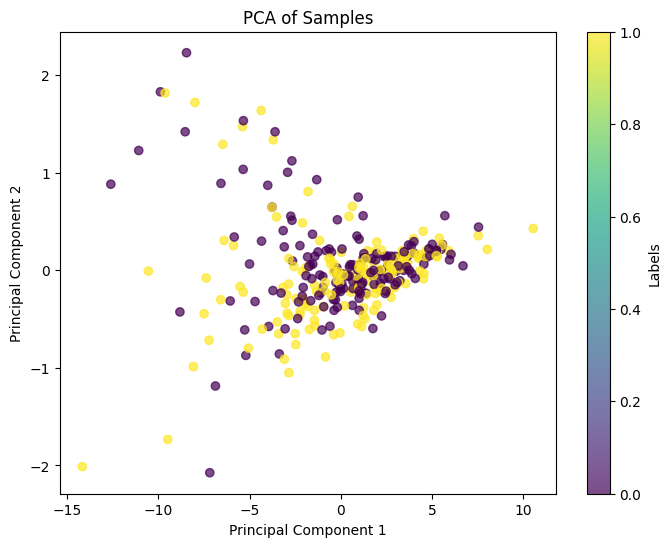

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)

samples_pcaed = pca.fit_transform(embedding_space)


# Plot PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(samples_pcaed[:, 0], samples_pcaed[:, 1], c=labels_list, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Samples")
plt.show()

In [11]:
# Now we can train from the output of the model



